In [2]:
import pandas as pd # type: ignore
from datetime import datetime # type: ignore
import numpy as np #type: ignore
from sklearn.metrics import mean_squared_error # type: ignore

In [3]:
df = pd.read_csv('datasets/dataset_PS.csv')
df = df.astype({'date': 'datetime64[ns]'})
df.head()

,date,consumption,temperature,precipitation,irradiation,cloudiness,holiday
0,2022-01-01 01:00:00,1018.0,-3.2,0.0,0.0,37.0,1.0
1,2022-01-01 02:00:00,975.0,-3.9,0.0,0.0,37.0,1.0
2,2022-01-01 03:00:00,944.0,-2.8,0.0,0.0,37.0,1.0
3,2022-01-01 04:00:00,936.0,-3.1,0.0,0.0,37.0,1.0
4,2022-01-01 05:00:00,952.0,-4.1,0.0,0.0,37.0,1.0


# Moja koda od tu naprej

Dodamo vse ostale stvari v model za train

In [4]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore

df_hourly = df.copy()
df_hourly['shifted_consumption_168'] = df_hourly['consumption'].shift(168)
df_hourly['shifted_consumption_48'] = df_hourly['consumption'].shift(48)
df_hourly['shifted_consumption_8760'] = df_hourly['consumption'].shift(8760)
df_hourly['hour'] = df_hourly['date'].dt.hour
df_hourly['weekDay'] = df_hourly['date'].dt.weekday

# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['date'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['date'] >= cutoff_date]

# LSTM

In [5]:
# Python
import pandas as pd # type: ignore
from prophet import Prophet # type: ignore

d:\Projects\Programming\Gen-I Trading Challenge\Task 1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df_hourly = df.copy()
df_hourly.rename(columns={'date': 'ds', 'consumption': 'y'}, inplace=True)
df_hourly.drop({'temperature', 'precipitation', 'irradiation', 'cloudiness', 'holiday'}, axis=1, inplace=True)
df_hourly = df_hourly.iloc[:-168, :]
df_hourly.head()

,ds,y
0,2022-01-01 01:00:00,1018.0
1,2022-01-01 02:00:00,975.0
2,2022-01-01 03:00:00,944.0
3,2022-01-01 04:00:00,936.0
4,2022-01-01 05:00:00,952.0


In [7]:
from prophet.make_holidays import make_holidays_df # type: ignore

si_holidays = make_holidays_df(
    year_list=[2022 + i for i in range(3)], country='SI'
)
si_holidays.head()

,ds,holiday
0,2024-01-01,New Year's Day
1,2024-01-02,New Year's Day
2,2024-02-08,Preseren's Day
3,2024-04-01,Easter Monday
4,2024-04-27,Day of Uprising Against Occupation


In [8]:
# Python
m = Prophet(holidays=si_holidays)
m.fit(df_hourly)

21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:25 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Python
future = m.make_future_dataframe(periods=7 * 24, freq="60min")
future.tail()

,ds
24615,2024-10-23 19:00:00
24616,2024-10-23 20:00:00
24617,2024-10-23 21:00:00
24618,2024-10-23 22:00:00
24619,2024-10-23 23:00:00


In [10]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
24615,2024-10-23 19:00:00,1605.747081,1414.152351,1787.125770
24616,2024-10-23 20:00:00,1579.273219,1406.054807,1756.324475
24617,2024-10-23 21:00:00,1488.715593,1298.158137,1663.872018
24618,2024-10-23 22:00:00,1379.617092,1208.226890,1565.723424
24619,2024-10-23 23:00:00,1289.934106,1125.501099,1470.556335


In [11]:
# forecast.tail(168).to_csv('forecast_Prophet_holidays.csv', index=False)

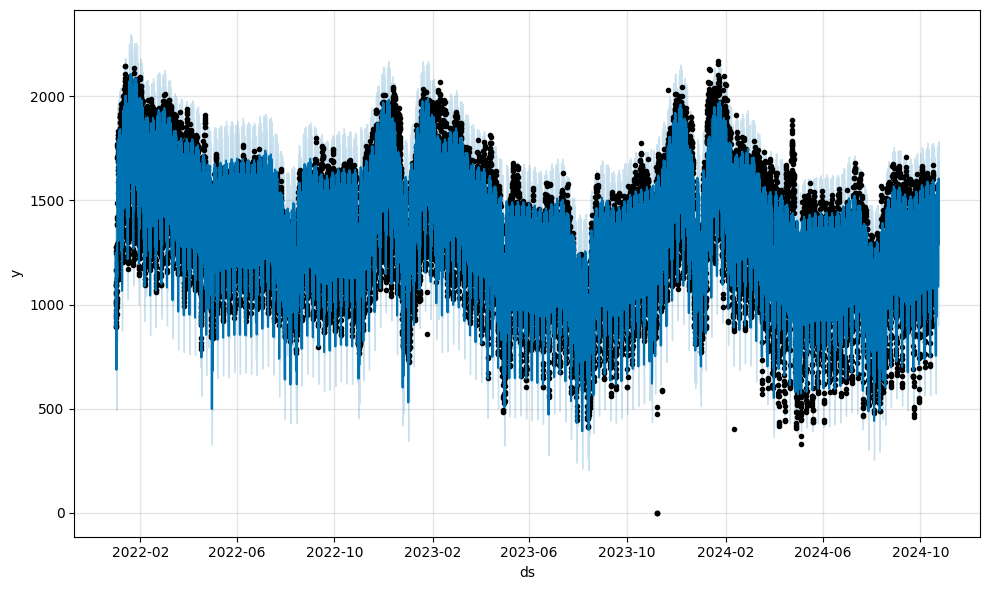

In [12]:
# Python
fig1 = m.plot(forecast)

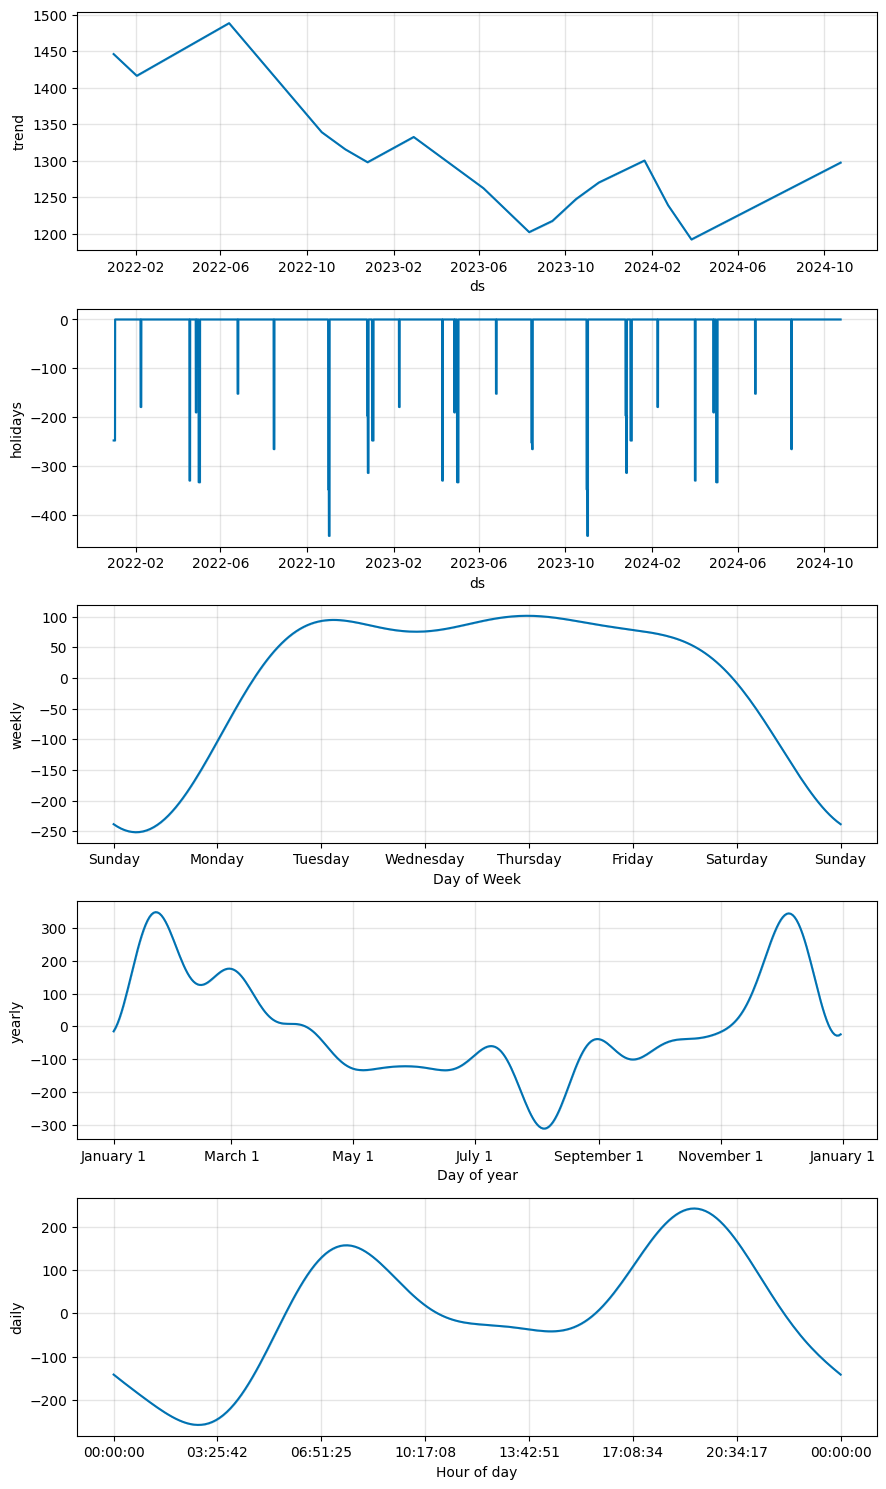

In [13]:
# Python
fig2 = m.plot_components(forecast)

In [14]:
actuals = pd.read_csv('forecasts/actuals.csv')
actuals.head()

,date,consumption
0,2024-10-17 00:00:00,1141.0
1,2024-10-17 01:00:00,1097.0
2,2024-10-17 02:00:00,1062.0
3,2024-10-17 03:00:00,1083.0
4,2024-10-17 04:00:00,1101.0


In [16]:
forecast2 = forecast[["ds", "yhat"]].tail(168).reset_index(drop=True)
forecast2.rename(columns={'yhat': 'consumption', "ds": "date"}, inplace=True)
# forecast2.to_csv('forecasts/forecast_Prophet_holidays.csv', index=False)

In [63]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error # type: ignore
from sktime.performance_metrics.forecasting import mean_squared_percentage_error # type: ignore

mse = root_mean_squared_error(actuals['consumption'], forecast2['consumption'])
mae = mean_absolute_error(actuals['consumption'], forecast2['consumption'])
mape = mean_absolute_percentage_error(actuals['consumption'], forecast2['consumption'])
rmspe = mean_squared_percentage_error(actuals['consumption'], forecast2['consumption'], square_root=True)

plt_title = 'MAE: {0:.2f}, RMSE: {1:.2f}, MAPE: {2:.2f}, RMSPE: {3:.2f}'.format(mae, mse, mape*100, rmspe*100)
print(plt_title)

MAE: 111.57, RMSE: 150.08, MAPE: 9.69, RMSPE: 14.63
